In [ ]:
using Pkg
Pkg.activate("../.")

using NetCDF, PyPlot, PyCall, ColorSchemes, QuadGK
import Statistics: mean

gspec = pyimport("matplotlib.gridspec")

PyPlot.matplotlib.rc("text", usetex=true)
PyPlot.matplotlib.rc("xtick", labelsize=7)
PyPlot.matplotlib.rc("ytick", labelsize=7)
PyPlot.matplotlib.rc("axes", labelsize=9)    # fontsize of the x and y labels
PyPlot.matplotlib.rc("font", family="sans-serif")
PyPlot.rc("text.latex", preamble="\\usepackage[T1]{fontenc} \\renewcommand*\\familydefault{\\sfdefault}  \\usepackage{sansmath}  \\sansmath");

In [2]:
snap1_layer1 = "layer1_tau5e-3_manyshortridgesCorrectTopo/"
snap2_layer1 = "layer1_tau1e-1_manyshortridges/"
snap3_layer1 = "layer1_tau1e-0_manyshortridgesCorrectTopo/"
snap4_layer1 = "layer1_tau8e-0_manyshortridgesCorrectTopo/"
snap1_layer2 = "layer2_tau5e-3_manyshortridgesCorrectTopo/"
snap2_layer2 = "layer2_tau1e-1_manyshortridgesCorrectTopo/"
snap3_layer2 = "layer2_tau1e-0_manyshortridgesCorrectTopo/"
snap4_layer2 = "layer2_tau8e-0_manyshortridgesCorrectTopo/"

snapshots = [[snap1_layer1, snap2_layer1, snap3_layer1, snap4_layer1],
             [snap1_layer2, snap2_layer2, snap3_layer2, snap4_layer2]]

tau = [0.005, 0.1, 1.0, 8.0];

In [3]:
xh, yh = ncread("../../data/layer1_tau1e-1_manyshortridges.nc", "xh"), ncread("../../data/layer1_tau1e-1_manyshortridges.nc", "yh")
nx, ny = length(xh), length(yh);
Lx, Ly = 3200, 1600

xmin, ymin = minimum(xh), minimum(yh)
x = [ xh[i]-xmin+2 for i=1:nx, j=1:ny]
y = [ yh[j] for i=1:nx, j=1:ny];

dx, dy = 4e3, 4e3; # [km]

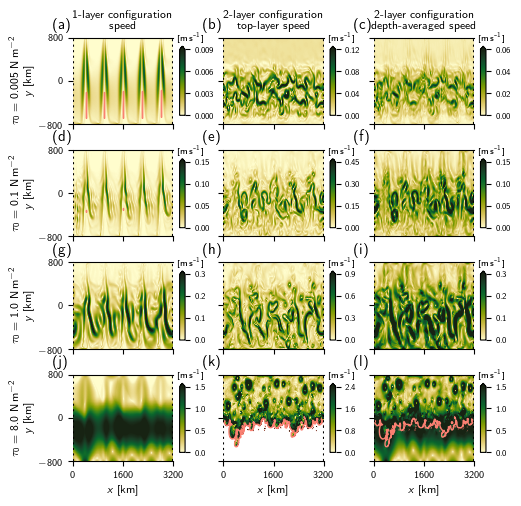

In [4]:
letters = "abcdefghijklmnopqrstuvwxyz"

fig, axs = subplots(4, 3, sharex = true, sharey = true, figsize=(5.5, 5.5))
subplots_adjust(hspace=0.3)

maxspeed1 =  [0.009, 0.15, 0.3, 1.5]
maxspeed2 =  [0.12 , 0.45, 0.9, 2.4]
maxspeedbt = [0.06 , 0.15, 0.3, 1.5]

cmspeed = ColorMap(ColorSchemes.speed.colors)

maxspeed = [maxspeed1, maxspeed2, maxspeedbt]
h1contour = 20

for i=1:2
    for j=1:4
        folder = snapshots[i][j]
        datafile = "../../data/"*snapshots[i][j][1:end-1]*".nc"
        u = circshift(dropdims(ncread(datafile, "u"), dims=(4)), (25, 0, 0))
        v = circshift(dropdims(ncread(datafile, "v"), dims=(4)), (25, 0, 0))
        h = circshift(dropdims(ncread(datafile, "h"), dims=(4)), (25, 0, 0))
        speed = @. sqrt(u^2+v^2)
        speed[h .< h1contour] .= NaN
        vmax = maxspeed[2][4]
        sca(axs[j, i])
        vmax = maxspeed[i][j]
        pcolormesh(x, y, speed[:, :, 1], vmin=0, vmax=vmax, cmap=cmspeed, rasterized=true)
        cb = colorbar(extend="max", ticks=range(0, stop=vmax, length=4), aspect=12, shrink=0.8)
        cb.ax.tick_params(labelsize=6) 
        contour(x, y, h[:, :, 1], levels=(h1contour,), colors="salmon", linewidths=1)
        if i==2
            speedbt = @. (sqrt(u^2+v^2)[:, :, 1]*h[:, :, 1] + sqrt(u^2+v^2)[:, :, 2]*h[:, :, 2]) / (h[:, :, 1] + h[:, :, 2])
            vmax = maxspeed[3][j]
            sca(axs[j, 3])
            pcolormesh(x, y, speedbt[:, :, 1], vmin=0, vmax=vmax, cmap=cmspeed, rasterized=true)
            cb = colorbar(extend="max", ticks=range(0, stop=vmax, length=4), aspect=12, shrink=0.8)
            cb.ax.tick_params(labelsize=6) 
            contour(x, y, h[:, :, 1], levels=(h1contour,), colors="salmon", linewidths=1)
        end
    end
end

for j=1:4
    sca(axs[j, 1])
    ylabel("\$\\tau_0 = "*string(tau[j])*"\$ N\$\\,\$m\$^{-2}\$ \n \$y\$ [km]", fontsize=8)
end
for j=1:3
    sca(axs[4, j])
    xlabel(L"$x$ [km]", fontsize=8)
end

sca(axs[1, 1])
title("1-layer configuration\n speed", fontsize=8)

sca(axs[1, 2])
title("2-layer configuration\n top-layer speed", fontsize=8)

sca(axs[1, 3])
title("2-layer configuration\n depth-averaged speed", fontsize=8)


for i=1:3, j=1:4
    sca(axs[j, i])
    xlim(0, Lx)
    ylim(-Ly/2, Ly/2)
    xticks(0:1600:Lx)
    yticks(-Ly/2:800:Ly/2)
    axs[j, i].plot([0, 0], [-Ly/2, Ly/2], ":k")
    axs[j, i].plot([Lx, Lx], [-Ly/2, Ly/2], ":k")
    axs[j, i].spines["left"].set_color("none")
    axs[j, i].spines["right"].set_color("none")
    annotate("("*string(letters[(j-1)*3+i])*")", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=11)
    annotate(L"[m$\,$s$^{\textrm{-}1}$]", xy=(1.04, 0.96), xycoords="axes fraction", fontsize=6)
end

savefig("snapshots.pdf", dpi=450, bbox_inches="tight")